# 1D Electromagnetic FDTD in Python

The <a href="https://en.wikipedia.org/wiki/Finite-difference_time-domain_method" target="_blank">finite difference time domain (FDTD)</a> algorithm is a numerical method used to solve partial differential equations which have both spatial and temporal derivatives such as <a href="https://en.wikipedia.org/wiki/Maxwell's_equations" target="_blank">Maxwell's equations</a> or <a href="https://en.wikipedia.org/wiki/Seismic_wave" target="_blank">seismic waves</a> propagating through the earth. Such equations are impossible to solve analytically for complex systems such as <a href="https://en.wikipedia.org/wiki/Random_laser" target="_blank">random lasers</a> or <a href="https://en.wikipedia.org/wiki/Volcano_tectonic_earthquake" target="_blank">volcanic systems</a>, and scientists have to make use of numerical methods to better understand how such systems behave under various conditions. In this post, we will explore how to implement the one dimensional electromagnetic FDTD algorithm in Python.

## Maxwell's Equations

As this post focuses on electromagnetism, we start from Maxwell's equations in Gaussian units, and scale the units such that the value of the speed of light _c_ = 1, and assume that no current _J_ is present in the system:

∇ · __E__ = 4πρ,

∇ · __B__ = 0,

∇ × __E__ = -__Ḃ__,

∇ × __B__  = __Ė__,

where __Ḃ__ and __Ė__ are the time derivatives of the magnetic field and electric field respectively.

## From Maxwell's Equations to FDTD

In order to implement the FDTD algorithm, we only need to use the third and fourth equations. The third equation can be written out more clearly as:

(∇ × __E__)<sub>i</sub> = ε<sub>ijk</sub>∇<sub>j</sub>_E_<sub>k</sub> = -_Ḃ_<sub>i</sub>,

i, j, k ∈ {_x_, _y_, _z_},

where ε<sub>ijk</sub> is the Levi-Civita symbol, ∇<sub>j</sub> is the jth spatial derivative, and _E_<sub>k</sub> is the kth spatial component of the electric field. For a 1 dimensional system where only ∇<sub>x</sub> exists, this reduces to the two equations:

-∇<sub>x</sub><i>E</i><sub>z</sub> = -_Ḃ_<sub>y</sub>, 

∇<sub>x</sub>_E_<sub>y</sub> = -_Ḃ_<sub>z</sub>.

Correspondingly, the fourth equation can be written out more clearly as:

(∇ × __B__)<sub>i</sub> = ε<sub>ijk</sub>∇<sub>j</sub>_B_<sub>k</sub> = _Ė_<sub>i</sub>,

i, j, k ∈ {_x_, _y_, _z_},

where _B_<sub>k</sub> is the kth spatial component of the magnetic field. Once again for a 1 dimensional system, this reduces to the two equations:

-∇<sub>x</sub>_B_<sub>z</sub> = _Ė_<sub>y</sub>, 

∇<sub>x</sub>_B_<sub>y</sub> = _Ė_<sub>z</sub>.

These four equations can be rearranged as the following pair of coupled partial derivative equations. In the first pair, we only have _E_<sub>z</sub> and _B_<sub>y</sub>:

-∇<sub>x</sub>_E_<sub>z</sub> = -_Ḃ_<sub>y</sub>, 

∇<sub>x</sub>_B_<sub>y</sub> = _Ė_<sub>z</sub>,

and in the second pair we only have _B_<sub>z</sub> and _E_<sub>y</sub>:

∇<sub>x</sub>_E_<sub>y</sub> = -_Ḃ_<sub>z</sub>, 

-∇<sub>x</sub>_B_<sub>z</sub> = _Ė_<sub>y</sub>.

As both coupled pairs are essentially the same system when considering spatial and temporal symmetry, we only need to choose and implement one pair numerically in order to implement the 1D FDTD algorithm. 

## The FDTD Grid

Now that we know which equations to solve numerically, we need to discretize the pair of coupled electric field and magnetic fields. Theoretically, the coupled equations must be solved simultaneously. This is obviously an impossible task when dealing with a numerical solution. Therefore in the FDTD method, we discretize the equations using a staggered spatial and temporal grid as shown in the figure below, which allows us to numerically approximate the simultaneous solving of both coupled equations.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_1d_grid.jpg?raw=True" alt="drawing" width="500"/>

Using the staggered FDTD grid shown in the figure above, the electric field (blue grid points) are evaluated at integer spatial indices ..., _i_ - 1, _i_, _i_ + 1, ... and integer temporal indices ..., _n_ - 1, _n_, _n_ + 1, ... while the magnetic field (red grid points) are evaluated at half-integer spatial indices ..., _i_ - 1/2, _i_ + 1/2, ... and half-integer temporal indices ..., _n_ - 1/2, _n_ + 1/2, ... 

Therefore, using the staggered FDTD grid, the first set of equations: 

-∇<sub>x</sub>_E_<sub>z</sub> = -_Ḃ_<sub>y</sub>, 

∇<sub>x</sub>_B_<sub>y</sub> = _Ė_<sub>z</sub>,

can be discretised as follows. -∇<sub>x</sub>_E_<sub>z</sub> = -_Ḃ_<sub>y</sub> is discretised as:

`-(Ez[i, n] - Ez[i - 1, n])/Δx = -(By[i - 1/2, n + 1/2] - By[i - 1/2, n - 1/2])/Δt`

where `Δx` and `Δt` are the spatial and temporal discretized grid step sizes respectively. Note that the first index `i` is the spatial index while the second index `n` is the temporal index. This can then be rearranged to the form:

`By[i - 1/2, n + 1/2] = By[i - 1/2, n - 1/2] - Δt(Ez[i, n] - Ez[i, n - 1])/Δx`

which forms our first discretized equation to use in the FDTD algorithm. Likewise, the equation ∇<sub>x</sub>_B_<sub>y</sub> = _Ė_<sub>z</sub> is discretized as:

`(By[i + 1/2, n - 1/2] - By[i - 1/2, n - 1/2])/Δx = (Ez[i, n] - Ez[i - 1, n])/Δt`

which can be rearranged to the form:

`Ez[i, n] = Ez[i, n - 1] - Δt(By[i + 1/2, n - 1/2] - By[i - 1/2, n - 1/2])/Δx`

which forms our second discretized equation to use in the FDTD algorithm.

In the same way, the second set of equations 

∇<sub>x</sub>_E_<sub>y</sub> = -_Ḃ_<sub>z</sub>, 

-∇<sub>x</sub>_B_<sub>z</sub> = _Ė_<sub>y</sub>.


can be discretised and rearranged as:

`Bz[i - 1/2, n + 1/2] = Bz[i - 1/2, n - 1/2] - Δt(Ey[i, n] - Ey[i - 1, n])/Δx`,

`Ey[i, n] = Ey[i, n - 1] - Δt(Bz[i + 1/2, n - 1/2] - Bz[i - 1/2, n - 1/2])/Δx`.

Note that it is sufficient to implement only one set of either sets, as both sets of equations are mathematically equivalent to each other.

## Coding the FDTD in Python

The entire 1D FDTD simulator is coded as a `fdtd1d` class. When initialized, the FDTD grid and simulation parameters are generated. Calling `run` executes the updates to both the electric and magnetic fields in time.

Note that the update for the electric field excludes the first and the last elements in the discretized grid. This results in the electric field at the two end points to always have the value of zero, which corresponds to a <a href="https://en.wikipedia.org/wiki/Perfect_conductor" target="_blank">perfect electrical conductor</a>. An electromagnetic wave striking a perfect electric conductor will always be fully reflected off the conducting surface. This will fully trap any generated electromagnetic waves within the FDTD grid.

Also, for the numerical simulation to be stable, the update step size must obey the <a href="https://en.wikipedia.org/wiki/Courant–Friedrichs–Lewy_condition" target="_blank">Courant condition</a>. This means that the time step size should obey the condition:

`dt = dx / (1.0 * c)`.

When executing the simulation, we also need to introduce a source into the grid in order to start the numerical solver. We introduce a source by simply adding a generated numerical value to the electric field at the desired source grid point.

## Absorbing Boundary Conditions

If we do not want to trap the generated electromagnetic wave within the grid, and allow it to dissipate through the grid end points, then we have to modify the grid with absorbing boundary conditions. The absorbing boundary conditions will absorb any electromagnetic wave that strikes the grid's end points, allowing the wave to dissipate out of the grid. Here we will use the Mur absorbing boundary conditions directly without derivation, and interested readers should read the original paper provided in the link. Equation 15 of the paper is implemented as:

`Ey[0, n + 1] = Ey[1, n] - (cΔt - Δx)/(cΔt + Δx)(Ey[1, n + 1] - Ey[0, n + 1])`


for the left most grid point, and as:

`Ey[Nx - 1, n + 1] = Ey[Nx - 2, n] - (cΔt - Δx)/(cΔt + Δx)(Ey[Nx - 2, n + 1] - Ey[Nx - 1, n + 1])`

for the right most grid point, where `Nx` is the FDTD grid size. This is implemented in Python as follows, and not implementing this part will result in the perfect electric conductor boundary mentioned earlier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from matplotlib.animation import FuncAnimation

# Usage:
# fdtd = fdtd1d()
# fdtd.run()
# fdtd.plot()

class fdtd1d(object):
    def __init__(self, Nx = 201, dx = 1e-3, c = 1, source = 100):
        # Grid properties:
        # 1. Number of grid cells
        self.Nx = Nx
        # 2. Grid cell size
        self.dx = dx
        # 3. Speed of light
        self.c = c
        # 4. Time step size (obeying Courant number)
        self.dt = dx / (1.0 * self.c)

        # Source properties:
        # 1. Source location array index
        self.source = source
        # 2. Source frequency, period etc.:
        frequency = 1 / (self.dt * 10)
        T0 = 1.0 / frequency
        tc = 5 * T0 / 2
        self.sig = tc / 2 / np.sqrt(2 * np.log(2))

        # Initialize grid:
        # 1. Electric field grid
        self.E_y = np.zeros(Nx)
        # 2. Magnetic field grid
        self.H_z = np.zeros(Nx - 1) 

        # Mur absorbing boundary conditions (ABC)
        # ABC for right side 
        self.E_y_h = 0 
        # ABC for left side
        self.E_y_l = 0

        # Record the time dependent electric field.
        self.E_t = []
        
        # Physical grid for plotting
        self.x = np.arange(0, Nx, 1)
        self.Dx = np.arange(0.5, Nx-0.5, 1)

    def run(self, n_iter = 180):
        # Main FDTD Loops
        dt = self.dt
        dx = self.dx
        c = self.c
        sig = self.sig
        source = self.source
        
        for n in tqdm.trange(n_iter):
            # Update magnetic field
            self.H_z = self.H_z - dt / dx * (self.E_y[1:] - self.E_y[:-1])     
    
            # Update electric field
            self.E_y[1:-1] = self.E_y[1:-1] - dt / dx * (self.H_z[1:] - self.H_z[:-1])
        
            # Initiate source to start the simulation
            pulse = np.exp((-((n+1) * dt - 3 * np.sqrt(2) * sig)**2) / (2 * sig**2))
            self.E_y[source] = self.E_y[source] + pulse
         
            # Absorbing boundary condition for right side of grid
            self.E_y[-1] = self.E_y_h + (c * dt - dx) / (c * dt + dx) * (self.E_y[-2] - self.E_y[-1])
            self.E_y_h = self.E_y[-2]
    
            # Absorbing boundary condition for left side of grid
            self.E_y[0] = self.E_y_l + (c * dt - dx) / (c * dt + dx) * (self.E_y[1] - self.E_y[0])
            self.E_y_l = self.E_y[1]
            
            self.E_t.append(self.E_y.copy())
        
    def plot(self):
        # plot the E_y and H_z fields in space
        plt.figure(figsize = (10, 5))
        plt.subplot(2, 1, 1)
        plt.plot(self.x, self.E_y)
        plt.ylabel("E_y")
        plt.grid(True)
        plt.subplot(2, 1, 2)
        plt.plot(self.Dx, self.H_z)
        plt.ylabel("H_x")
        plt.grid('on')
        plt.xlabel("x")
        plt.show()
        
    def animate(self, file_dir = "fdtd_1d_animation.gif", N = 500):
        # animate self.Et as a .gif file.
        # N: number of total steps to save as .gif animation.
        Et = self.E_t[-N:]
        
        fig, ax = plt.subplots()
        ax.set(xlim = [-10, 210], ylim = [-1, 1])
        line = ax.plot(range(len(Et[0])), Et[0], color = "r", linewidth = 2)[0]
        ax.set_xlabel("x")
        ax.set_ylabel("Electric field")
        ax.grid(True)

        def animate(i):
            line.set_ydata(Et[i])

        anim = FuncAnimation(fig, animate, interval = 50, frames = len(Et) - 1)
        anim.save(file_dir, writer = "pillow") 
        plt.show()

## Running the Simulation

Finally, a simple simulation using the default setup can be run as shown below.

100%|██████████| 80/80 [00:00<00:00, 14139.49it/s]


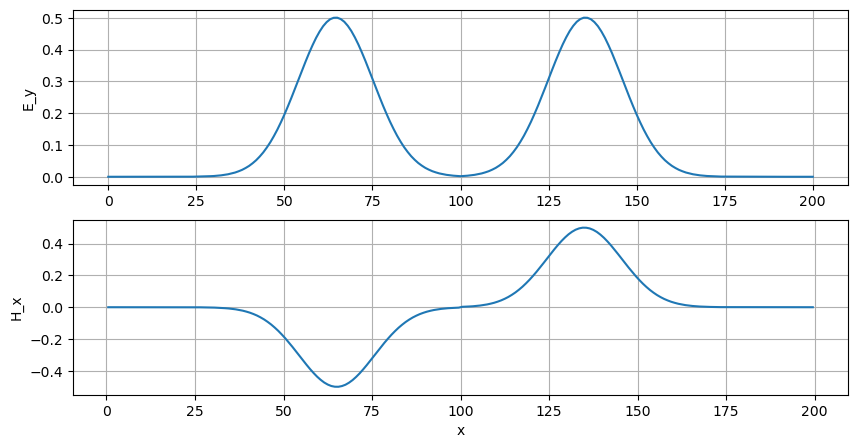

In [2]:
fdtd = fdtd1d() # Create simulator. 
fdtd.run(80) # Execute simulation for 80 time steps.
fdtd.plot() # Plot the electric and magnetic fields.

## FDTD Animation

A function to animate the simulation built into `fdtd1d` and can be called using: `fdtd.animate()`. The animation is saved directly into a `.gif` file. The gif animation below shows the entire FDTD simulation. A pulse is generated at the centre of the grid, which then propagates outwards through the absorbing boundary conditions situated at both ends of the grid.

<img src="https://github.com/natsunoyuki/blog_posts/blob/main/images/fdtd_1d_animation.gif?raw=True" alt="drawing" width="500"/>

## More Advanced Simulations

This simulation was a pretty simple one involving solving Maxwell's equations in time and space with no other complex structures involved. However the FDTD simulation is commonly used to solve for more complex systems such as lasers, coupled optical resonators etc. I cover the simulation for a 1D laser in <a href="https://github.com/natsunoyuki/blog_posts/blob/main/physics/1D%20Laser%20Simulation%20in%20Python.ipynb" target="_blank">another post</a>.

***

More FDTD codes can be found on my <a href="https://github.com/natsunoyuki/FDTD" target="_blank">Github repository</a> where I am working on both 1D and 2D laser simulations.